In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:,2:], iris.target

In [2]:
from sklearn.metrics import accuracy_score
from collections import Counter
import numpy as np

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

In [3]:
def calcularProbabilidades(y):
    labels = list(set(y))
    labels.sort()
    
    probabilidades = np.zeros((len(labels)),)
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)

    return probabilidades

In [4]:
# Gini
def impureza(y):
    probabilidades = calcularProbabilidades(y)

    result = 1 - sum(probabilidades**2)

    return result

print(impureza(y))

0.6666666666666667


In [20]:
from math import log

def impurezaEntropy(y):
    probabilidades = calcularProbabilidades(y)

    result = 0
    for prob in probabilidades:
        result -= prob * log(prob, 2)

    return result

print(impurezaEntropy(y))

1.584962500721156


In [5]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

def plotDecisao (modelo, X, y):
    modelo.fit(X, y)    

    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    y_pred = modelo.predict(Xdec)
    plt.contourf(x0, x1, y_pred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], "o", label=f"{iris.target_names[k]} [k]")
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.legend()
    plt.show()

In [6]:
def impurezaValor(x, y, valor):
    maiores = x > valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)    
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores

impurezaValor(X[:,0], y, 2.5)

(0.3333333333333333, 0.5, 0.0)

In [36]:
def entropy(prob):
    if prob == 0:
        return 0

    return prob*log(prob,2)

In [42]:
def impurezaValorEntropy(x, y, valor):
    maiores = x > valor
    impurezaMaiores = impurezaEntropy(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impurezaEntropy(y[~maiores])
    propMenores = sum(~maiores)/len(y)    
    impurezaTotal = 0    
    impurezaTotal -= entropy(propMaiores) + entropy(propMenores)
    return impurezaTotal, impurezaMaiores, impurezaMenores

impurezaValorEntropy(X[:,0], y, 2.5)

(0.9182958340544896, 1.0, 0.0)

In [33]:
def melhorValor(x, y, criterion="gini"):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    iteracao = 0
    while True:
        iteracao += 1
        valor = (xmin+xmax)/2

        impTotal = 0.0
        impMaiores = 0.0
        impMenores = 0.0
        if criterion=="gini":
            impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        else:            
            impTotal, impMaiores, impMenores = impurezaValorEntropy(x, y, valor)

        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break

    return result, menorImpureza

melhorValor(X[:,0], y)
melhorValor(X[:,0], y, criterion="entropy")

0.5933333333333334 0.4066666666666667
0.6666666666666666 0.3333333333333333


(2.475, 0.9182958340544896)

In [28]:
def melhorCaracteristica(X, y, level=1, criterion="gini"):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y, criterion=criterion)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    valores = np.array(valores)
    if level == 0:
        caracteristica = np.argmin(valores)
    else:
        caracteristica = np.argmin(impurezas)    
    return caracteristica, valores[caracteristica], impurezas[caracteristica]
print(melhorCaracteristica(X, y))
print(melhorCaracteristica(X, y, level=0, criterion="entropy"))

(0, 2.475, 0.3333333333333333)
(1, 1.9, 0.7083926867030441)


In [41]:
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):

    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X, y)        
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:            
            self.resposta = maisFrequente(y)

    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:, self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])

        return y

# maisFrequente(y)

modelo = Arvore()
modelo.fit(X, y)
y_pred = modelo.predict(X)

accuracy = accuracy_score(y, y_pred)
print(accuracy)

0.9933333333333333


In [43]:
class ArvoreNova(BaseEstimator, ClassifierMixin):

    def __init__(self):
        self.level = 0
    
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X, y, level=self.level, criterion="entropy")
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = ArvoreNova()
            self.maiores.level = self.level + 1
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = ArvoreNova()
            self.menores.level = self.level + 1
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:            
            self.resposta = maisFrequente(y)

    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:, self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])

        return y

# maisFrequente(y)

modelo = ArvoreNova()
modelo.fit(X, y)
y_pred = modelo.predict(X)

accuracy = accuracy_score(y, y_pred)
print(accuracy)

0.9733333333333334


implementação original


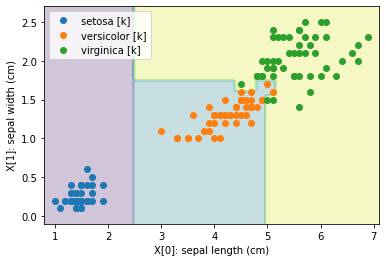

nova heurística


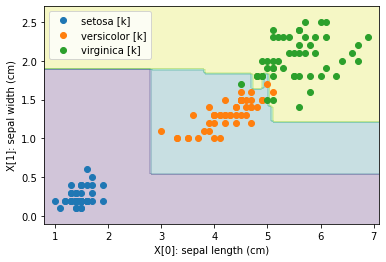

implementação sklearn


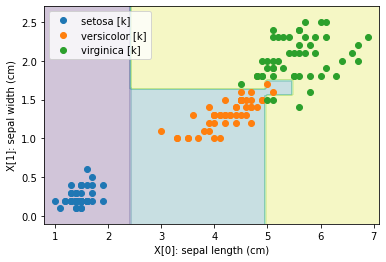

In [44]:
from sklearn.tree import DecisionTreeClassifier

modelos = { "implementação original": Arvore(), "nova heurística": ArvoreNova(), "implementação sklearn": DecisionTreeClassifier() }

for key in modelos.keys():
    print(key)
    plotDecisao(modelos[key], X, y)

In [46]:
datasets = { 
    "glass classification": { "path": "./dataset/glass.csv", "target": "Type", "X": None, "y": None },
    "fetal health classification": { "path": "./dataset/fetal_health.csv", "target": "fetal_health", "X": None, "y": None },
    "mobile price classification": { "path": "./dataset/mobile_price_train.csv", "target": "price_range", "X": None, "y": None }
}

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from sklearn.preprocessing import LabelEncoder

for key in datasets.keys():
    print("\n", key, "\n")

    dataset = datasets[key]
    data = pd.read_csv(dataset["path"])

    data = data.dropna()

    print(data.shape)

    data.info()

    data.head()

    target = dataset["target"]

    dataset["X"] = data.drop(columns=[target])
    dataset["y"] = data[target]

    print(dataset["X"].shape, dataset["y"].shape)
    print(set(dataset["y"]))


 glass classification 

(214, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.4 KB
(214, 9) (214,)
{1, 2, 3, 5, 6, 7}

 fetal health classification 

(2126, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   basel